## Step 5: Training on the merged dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras import regularizers
from keras.optimizers import Nadam

from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import matplotlib.dates as mdates


### 5.1. Importing the dataset

In [3]:
# Load the data
csvFilePath = './data/stocks/GoogleWithSentiments.csv'
df = pd.read_csv(csvFilePath)


### 5.2. Creating a function to preprocess the dataset

In [4]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)

### 5.3. Preproccessing the dataset for GRU

In [5]:
features = df.drop(['Date', 'Close'], axis=1).values
target = df['Close'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 3
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

# Reshaping data for GRU (3D input: samples, timesteps, features)
trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))

[[[0.01320788 0.0140359  0.01486486 0.0692677  0.04399918 0.10222734
   0.20118126 0.58803874 0.67310649]
  [0.01105012 0.01094974 0.01079181 0.12858584 0.00805799 0.01927651
   0.07894002 0.56344851 0.79445653]
  [0.00841725 0.00827058 0.00588643 0.18214242 0.03382167 0.05506249
   0.1688246  0.59605769 0.71035546]]

 [[0.01105012 0.01094974 0.01079181 0.12858584 0.00805799 0.01927651
   0.07894002 0.56344851 0.79445653]
  [0.00841725 0.00827058 0.00588643 0.18214242 0.03382167 0.05506249
   0.1688246  0.59605769 0.71035546]
  [0.00463623 0.00442969 0.0051225  0.15172887 0.28945064 0.24301111
   0.24223257 0.50074129 0.43390071]]]
[[0.00323637]
 [0.00394044]]


### 5.4. Building the GRU model

In [6]:
from keras import backend as K
K.clear_session()


In [7]:
batch_size = 32        
epochs = 150           
neurons = 256          
dropout_rate = 0.6     
learning_rate = 0.0001 

model = Sequential()

model.add(GRU(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout_rate))

model.add(GRU(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout_rate))

model.add(GRU(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout_rate))

model.add(GRU(neurons, activation='tanh'))
model.add(Dropout(dropout_rate))

model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00001)))

optimizer = Nadam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, 
                    validation_split=0.25, callbacks=[early_stopping])
model.summary()

c:\Users\mjvis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0290 - val_loss: 0.1707
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0077 - val_loss: 0.0777
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 9.7202e-04
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0020 - val_loss: 9.6167e-04
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016 - val_loss: 9.7318e-04
Epoch 8/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - val_loss: 9.4460e-04
Epoch 9/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0013 - val_loss: 9.1758e-04
Epoch 11/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/150
43/43 ━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 3, 256)         │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 3, 256)         │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 3, 256)         │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217,478 (16.09 MB)

 Trainable params: 1,405,825 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,811,653 (10.73 MB)

### 5.5. Testing the model
#### 5.5.1. Running prediction over the training set and testing set

In [8]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


#### 5.5.2. Calculating the score and accuracy of the model

In [9]:
train_rmse = np.sqrt(mean_squared_error(trainYInv[:, 0], trainPredictInv[:, 0]))
train_mae = mean_absolute_error(trainYInv[:, 0], trainPredictInv[:, 0])
train_r2 = r2_score(trainYInv[:, 0], trainPredictInv[:, 0])
train_accuracy = 100 - (train_rmse / np.mean(trainYInv) * 100)

test_rmse = np.sqrt(mean_squared_error(testYInv[:, 0], testPredictInv[:, 0]))
test_mae = mean_absolute_error(testYInv[:, 0], testPredictInv[:, 0])
test_r2 = r2_score(testYInv[:, 0], testPredictInv[:, 0])
test_accuracy = 100 - (test_rmse / np.mean(testYInv) * 100)

metrics_data = {
    'Metric': ['RMSE', 'MAE', 'R²', 'Accuracy'],
    'Training Set': [train_rmse, train_mae, train_r2, train_accuracy],
    'Testing Set': [test_rmse, test_mae, test_r2, test_accuracy]
}

metrics_df = pd.DataFrame(metrics_data)

print(metrics_df)


     Metric  Training Set  Testing Set
0      RMSE      1.819584     3.591801
1       MAE      1.224904     2.816072
2        R²      0.996790     0.948871
3  Accuracy     97.139164    96.862398


In [10]:
# For GRU
model.save('models/gru_model.h5')

#### 5.5.3. Visualizing the data

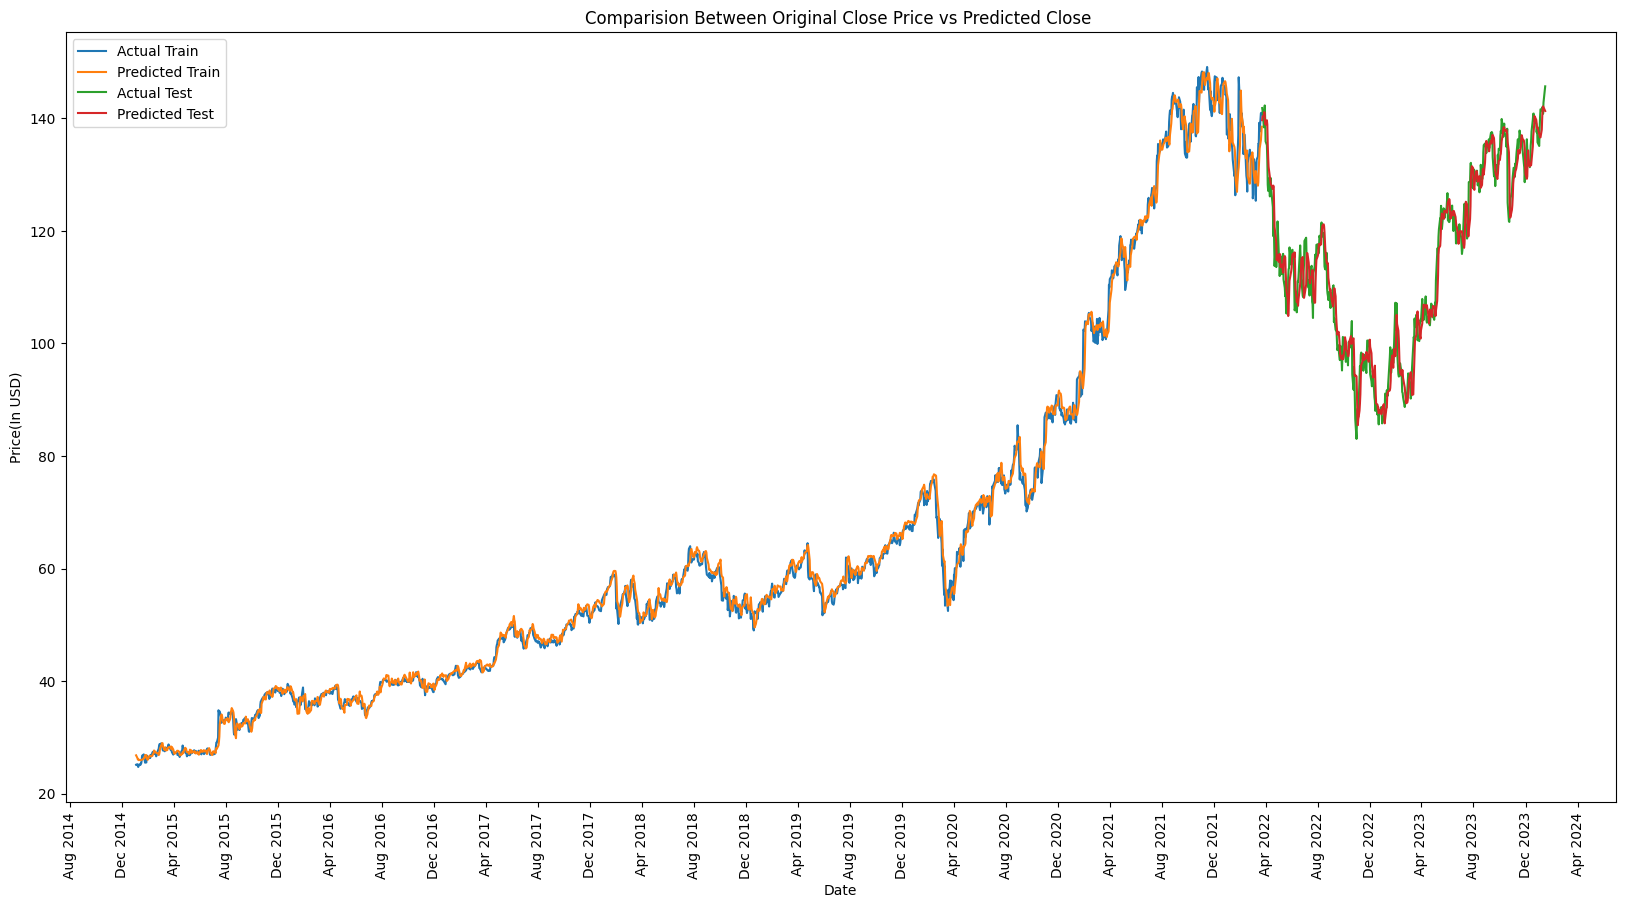

In [11]:
dates = pd.to_datetime(df['Date']).values
sampleInterval = 60
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))

plt.plot(dates[:len(trainY)], trainYInv, label='Actual Train')
plt.plot(dates[:len(trainPredict)], trainPredictInv, label='Predicted Train')
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testYInv, label='Actual Test')
plt.plot(dates[len(trainPredict):len(trainPredict) + len(testPredict)], testPredictInv, label='Predicted Test')
plt.title("Comparision Between Original Close Price vs Predicted Close ")

plt.xlabel("Date")
plt.ylabel("Price(In USD)")  
plt.xticks(rotation=90)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.legend()
plt.show()